Synchronize DLC results with xr_session

In [64]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data
from moviepy.editor import *


In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
def add_video_timestamp(df,videofile):
    # add timestamp of the video file to the deeplabcut dataframe
    ts = dlc_utils.extract_video_timestamp(videofile)
    df['time'] = ts
    df = df.set_index('time')
    return df

dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)
    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Get the photometry signal based on speed trigger

In [125]:
signal_time, coords, speed, accel = dlc_utils.get_movement_metrics(wrist_loc)
speed_mag = np.linalg.norm(speed,axis=1)
accel_mag = np.diff(speed_mag, prepend=speed_mag[0])

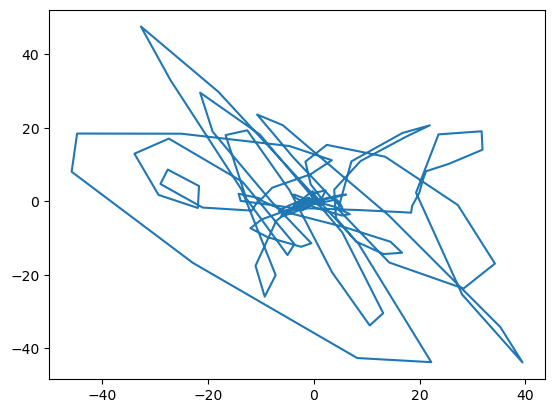

In [126]:
plt.plot(speed[:1000,0], speed[:1000,1])

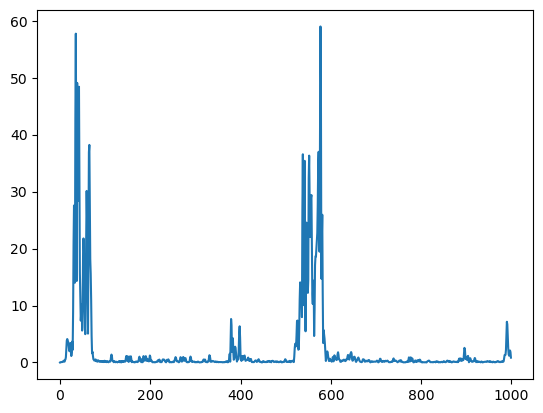

In [127]:
plt.plot(speed_mag[:1000])

**Direction of axis in image:**

- x: increase from left to right
- y: increase from top to bottom
- speed_x: -ve : left
- speed_y: -ve : up

In [128]:
f = xr_session.zscored_df_over_f.data[0]

df_move = pd.DataFrame({
    'accel': accel_mag,
    'accel_x': accel[:,0],
    'accel_y': accel[:,1],
    'speed': speed_mag,
    'speed_x': speed[:,0],
    'speed_y': speed[:,1],
    'time': xr_session.time,
    'df/f': f})
df_move

,accel,accel_x,accel_y,speed,speed_x,speed_y,time,df/f
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7608.5,0.205254
1,0.057733,0.014156,-0.055971,0.057733,0.014156,-0.055971,7618.5,0.292358
2,-0.014141,0.028642,0.047690,0.043592,0.042798,-0.008280,7628.5,0.262030
3,0.027108,0.027034,-0.002757,0.070699,0.069833,-0.011037,7638.5,0.201862
4,0.015841,0.012326,-0.016152,0.086541,0.082158,-0.027190,7648.5,0.231352
...,...,...,...,...,...,...,...,...
176423,0.047227,-1.242300,0.265860,0.658829,-0.644407,0.137092,1771827.5,0.003056
176424,2.613453,-2.555329,0.548121,3.272282,-3.199736,0.685213,1771837.5,0.031638
176425,1.856771,-1.815902,0.387428,5.129054,-5.015639,1.072641,1771847.5,0.086082
176426,-0.771006,0.751912,-0.170858,4.358047,-4.263727,0.901783,1771857.5,0.064148


In [138]:
df_accel_forward = dlc_utils.accelerate_forward(df_move, accel_threshold=5, speed_threshold=10)
df_accel_forward

,accel,accel_x,accel_y,speed,speed_x,speed_y,time,df/f
29,6.747229,-6.147158,-7.356325,8.951048,-7.145182,-5.391442,7898.5,-0.589922
1747,6.924571,-7.024784,-3.606804,7.989691,-6.557769,-4.564080,25078.5,1.025637
1772,6.624754,-6.133382,-3.613977,8.383483,-7.803723,-3.063443,25328.5,-0.229213
2773,6.759022,-7.207261,-4.481096,8.992257,-8.572894,-2.714069,35338.5,3.197638
3230,5.474919,-3.845573,-4.375101,6.411251,-3.628207,-5.285854,39908.5,-2.016429
...,...,...,...,...,...,...,...,...
173606,7.072777,-8.016836,0.566882,7.685679,-7.685508,0.051256,1743657.5,0.022175
174681,7.281373,0.273762,-8.000275,8.133495,-0.570812,-8.113440,1754407.5,-0.839283
174750,5.597032,-3.122523,-4.707783,8.949253,-5.546938,-7.022863,1755097.5,-0.837675
175543,6.099643,-6.684888,-1.906788,6.752674,-6.634900,-1.255672,1763027.5,-0.002133


## Identify contagious regions

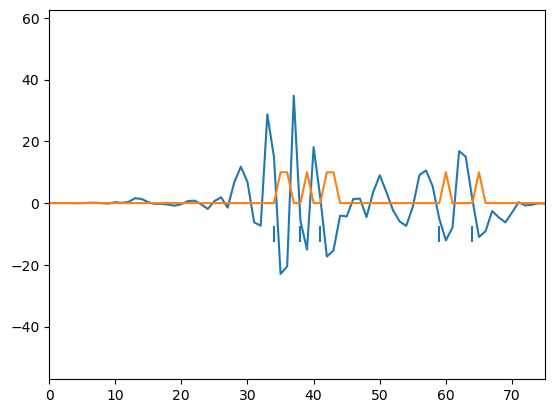

In [130]:
fig,ax = plt.subplots()

a = np.diff(speed_mag)


condition  = (a<-10).astype(np.int8)

ax.plot(a)
ax.plot(condition*10)
ax.set_xlim([0,75])

event_idx = np.where(np.diff(condition)==1)[0]
ax.eventplot(event_idx, lineoffset=-10, linelength=5)

event_time = xr_session.time[event_idx]
# event_time = np.random.choice(xr_session.time,1000)

(0.0, 200.0)

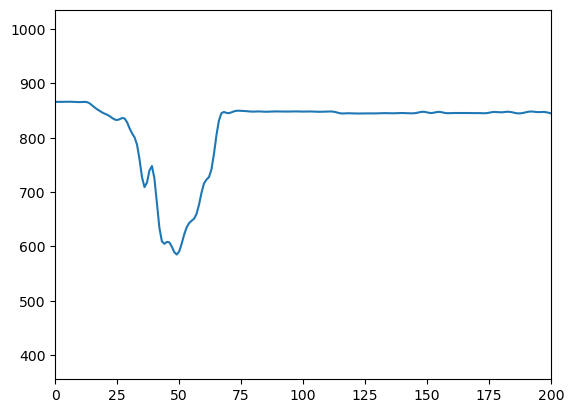

In [15]:
plt.plot(coords[:,0])
plt.xlim([0,200])

 Things to study
 - Forward aceleration and backward acceleration
 - acceleraton and deceleration

## Extract photometry data based on movement

<Axes: xlabel='event_time', ylabel='photometry'>

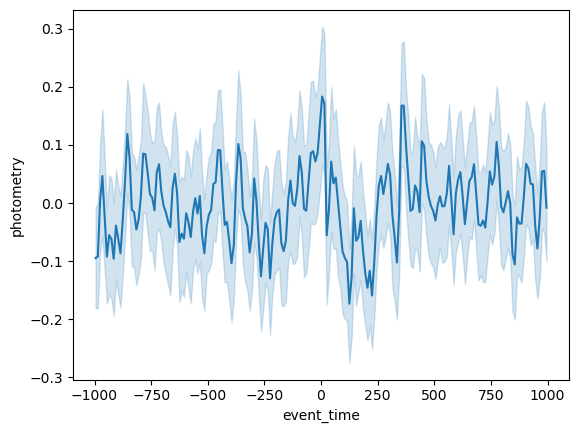

In [139]:
df_forward = dlc_utils.extract_triggered_data(df_accel_forward.time, xr_session)
sns.lineplot(df_forward, x='event_time', y='photometry')

In [122]:
df_trigger = dlc_utils.extract_trigger_acceleration(df_move, accel_threshold=5, 
                                                            speed_threshold=5, accel_type='decel', 
                                                            direction='forward')
df_trigger

,accel,accel_x,accel_y,speed,speed_x,speed_y,time,df/f


In [147]:
df2plot = []
for accel_type in ['accel','decel']:
    for direction in ['forward','backward']:
        df_trigger = dlc_utils.extract_trigger_acceleration(df_move, accel_threshold=10, 
                                                            speed_threshold=20, accel_type=accel_type, 
                                                            direction=direction)
        # display(df_trigger)
        df = extract_triggered_data(df_trigger.time, xr_session)
        df['type'] = f'{accel_type}_{direction}'
        df2plot.append(df)
        
df2plot = pd.concat(df2plot).reset_index()
df2plot

,index,event_index,event_time,photometry,type
0,0,0,-995.497749,-2.569674,accel_forward
1,1,0,-985.492746,-2.730499,accel_forward
2,2,0,-975.487744,1.241439,accel_forward
3,3,0,-965.482741,4.927424,accel_forward
4,4,0,-955.477739,3.223039,accel_forward
...,...,...,...,...,...
287995,37395,186,955.477739,0.029317,decel_backward
287996,37396,186,965.482741,0.068304,decel_backward
287997,37397,186,975.487744,0.173998,decel_backward
287998,37398,186,985.492746,0.084797,decel_backward


In [ ]:
sns.relplot(df2plot, kind='line', x='event_time', y='photometry', hue='type', row='type')

## Distribution analysis

<Axes: xlabel='accel', ylabel='df/f'>

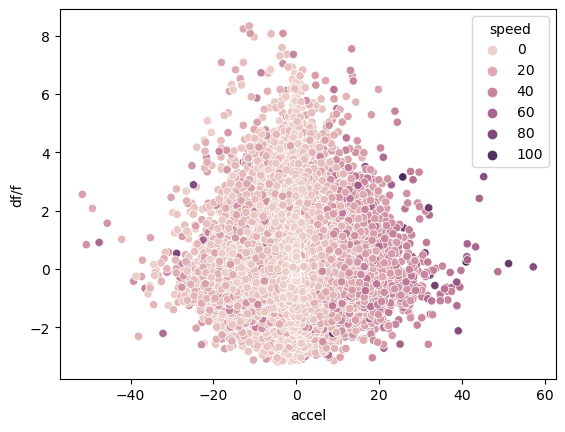

In [12]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

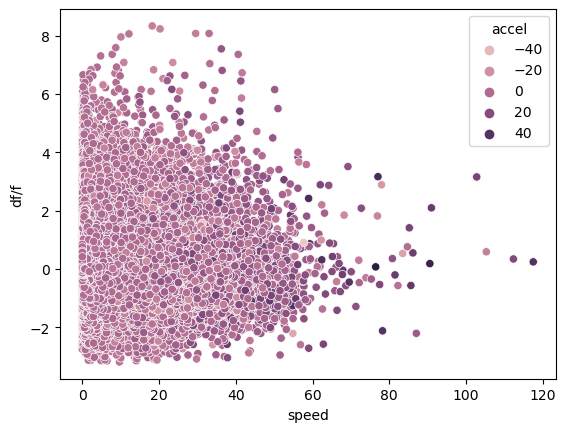

In [13]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')